# Objetivos deste trabalho:
- Se familiarizar com o ambiente Notebook e com Python
- Implementar um perceptron simples, treiná-lo no conjunto de TREINO do CIFAR-10 e avaliá-lo no conjunto de TESTE (alvo: distinguir fotos de animais de meios de transporte)
- Utilizar a função sigmóide e verificar seu efeito no treinamento e na avaliação
- Modificar a metodologia para classificar cada classe individualmente (i.e. treinar 10 perceptrons, um para cada classe). Considerar: dado um exemplo, que passará por cada perceptron, como decidir qual é a classe dele?

In [1]:
# imports and config
%matplotlib inline

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# load CIFAR10 datasets

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# CIFAR10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# print length of train and test data
print(len(dataset_train), len(dataset_test))

50000 10000


In [5]:
# convert to shades of grey

# train
grayscale_dataset_train = []
for img,label in dataset_train:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_train.append((gray_npimg,category))
    
# test
grayscale_dataset_test = []
for img,label in dataset_test:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_test.append((gray_npimg,category))    

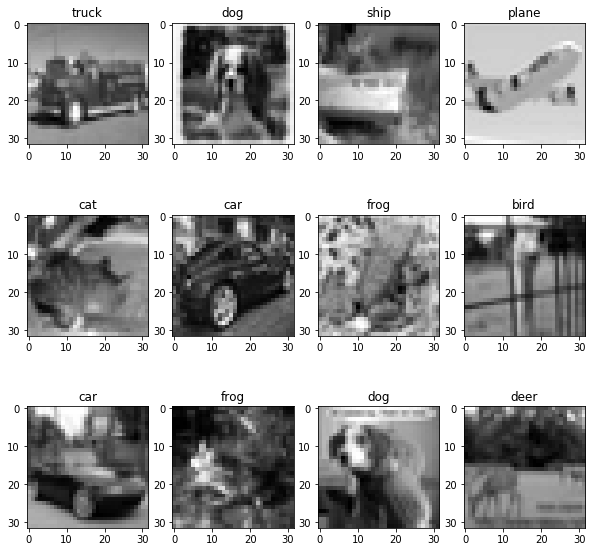

In [6]:
# show a few train images

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    image_index = random.randint(0, len(dataset_train))
    label = grayscale_dataset_train[image_index][1]
    npimg = grayscale_dataset_train[image_index][0]

    fig.add_subplot(rows, columns, i)
    
    plt.imshow(npimg, cmap='gray')
    plt.title(label)
    
plt.show()

In [7]:
# Converter para vetores 1D

# Para pensar: por que a divisão por 255 no código abaixo?
# Técnica de normalização, serve para evitar weights de magnitudes muito elevadas, 
# visto que é a relação entre eles que prevalece.

# Como os valores dos pixels vão de 0 até 255, dividir eles pelo máximo resulta num valor entre 0 e 1.

linear_dataset_train = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_train:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_train.append((linear_img,label))
    
linear_dataset_test = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_test.append((linear_img,label))    

In [8]:
size = len(linear_dataset_train[0][0])
print(size)

1024


# Definindo o perceptron
Perceptron foi definido como uma classe, para facilitar interpretação e utilização.

In [9]:
class Perceptron(object):
    
    def __init__(self, neta=0.001):
        self.neta = neta
        self.weights = (np.random.rand(1,size) - 0.5)[0]
        bias = (np.random.rand(1) - 0.5) 
        self.weights = np.append(self.weights, bias) 
        self.accuracies = []
        self.losses = []
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def predict(self, inputs):
        o = np.dot(inputs, self.weights)
        y = self.sigmoid(o)
        return y
    

    def evaluate(self, dataset):
        hits = 0
        for image,label in dataset:
            image = np.append(image, 1)
            # Defina a métrica de avaliação do perceptron aqui (e.g. acurácia)
            y = self.predict(image)

            if(y >= 0.5 and label == 1):
                hits += 1

            elif(y < 0.5 and label == 0):
                hits += 1

        accuracy = hits / len(dataset)
        return accuracy
    
    # balance multiplier is used to reward the perceptron on true positives (for unbalanced datasets)
    def train(self, dataset, epochs=100, verbose="not_verbose", balance_multiplier=1):
        np.random.shuffle(dataset)

        for epoch in range(epochs):
            hits = 0
            loss = 0
            for image, label in dataset:
                image = np.append(image, 1)
                
                y = self.predict(image)
                reward = 1
                
                    
                if label == 1:
                    reward = balance_multiplier
                    
                if(y >= 0.5 and label == 1):
                    hits += 1
                    

                elif(y < 0.5 and label == 0):
                    hits += 1

                delta_weights = self.neta * (label - y) * image * y * (1 - y) * reward
                self.weights += delta_weights
                loss += (label - y)**2

            accuracy = hits / len(linear_dataset_train)
            self.accuracies = np.append(self.accuracies, accuracy)
            self.losses = np.append(self.losses, loss)

            if(verbose == "verbose"):
                print("%5.0f %12f %15f" %(epoch+1, accuracy, loss))
                #print(epoch,"\t", accuracy, "\t", loss)
            
    
    def plotResults(self):
        plt.plot(self.accuracies)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy")
        plt.show()

        plt.plot(self.losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()

# Treinando o perceptron

In [10]:
p0 = Perceptron()
p0.train(linear_dataset_train, 100, "verbose")

    1     0.651540    11992.404261
    2     0.693600    10805.754343
    3     0.701280    10562.438002
    4     0.706180    10405.070849
    5     0.708620    10287.911601
    6     0.710800    10195.578404
    7     0.712320    10119.819121
    8     0.713720    10055.701592
    9     0.714280    10000.203591
   10     0.715500     9951.408747
   11     0.716400     9908.040150
   12     0.717480     9869.197680
   13     0.718200     9834.211182
   14     0.719180     9802.557618
   15     0.720100     9773.813303
   16     0.720860     9747.625508
   17     0.721560     9723.694894
   18     0.722320     9701.764120
   19     0.722840     9681.610028
   20     0.722940     9663.038011
   21     0.723620     9645.877721
   22     0.724000     9629.979662
   23     0.724740     9615.212403
   24     0.724940     9601.460232
   25     0.724860     9588.621149
   26     0.725220     9576.605148
   27     0.725320     9565.332709
   28     0.725440     9554.733501
   29     0.725640  

In [11]:
# Avalie o modelo treinado aqui
# Como a acurácia no conjunto de teste se compara com a acurácia obtida no conjunto de treino?

# A acurácia no conjunto de treino é maior devido ao overfitting do conjunto de treinamento.
# Analogamente, a acurácia do conjunto de teste é menor justamente pelo fato de que as imagens do 
# conjunto de teste nunca foram apresentadas ao modelo.

accuracy_train = p0.evaluate(linear_dataset_train)
accuracy_test = p0.evaluate(linear_dataset_test)

print("Train Accuracy: ", accuracy_train, "\tTest Accuracy: ", accuracy_test)


Train Accuracy:  0.72936 	Test Accuracy:  0.7147


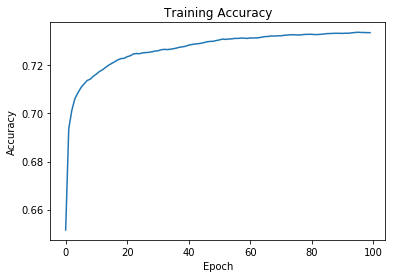

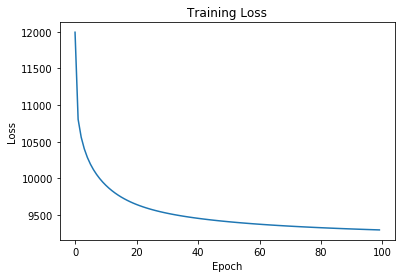

In [12]:
# Caso queiram plotar alguma coisa

p0.plotResults()


# Classificando classes individuais

Implemente aqui a modificação do processo de avaliação e treinamento para poder classificar cada classe individualmente.

- Ideia geral: treinar um perceptron por classe (exemplo positivo = exemplos da classe; exemplos negativos = exemplo de todas outras classes)
- Dado um exemplo qualquer, como decidir qual perceptron está dando a classe correta?

Pode ser decidido simplesmente pelo perceptron do arranjo com a saída maior.

In [13]:
def classes_get(x):
    return {
        0: "plane",
        1: "car",
        2: "bird",
        3: "cat",
        4: "deer",
        5: "dog",
        6: "frog",
        7: "horse",
        8: "ship",
        9: "truck",
    }[x]

In [14]:
# converter para vetores 1D

linear_dataset_array_train = [[] for i in range(10)]
linear_dataset_array_test = [[] for i in range(10)]

for index in range(10):
    
    target_labels = classes_get(index)
    for img,category in grayscale_dataset_train:
        linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
        #linear_img = img
        if category in target_labels:
            label = 1
        else:
            label = 0
        linear_dataset_array_train[index].append((linear_img,label))

    
    
    for img,category in grayscale_dataset_test:
        linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
        #linear_img = img
        if category in target_labels:
            label = 1
        else:
            label = 0
        linear_dataset_array_test[index].append((linear_img,label))
    

In [15]:
# size of train dataset list and train dataset for perceptron 0
print(len(linear_dataset_array_train))
print(len(linear_dataset_array_train[0]))

# size of test dataset list and test dataset for perceptron 0
print(len(linear_dataset_array_test))
print(len(linear_dataset_array_test[0]))

10
50000
10
10000


############################################
Training Perceptron 0
    1     0.429800    20058.352111
    2     0.512460    15340.387688
    3     0.533420    14569.849570
    4     0.546520    14023.358514
    5     0.557860    13623.282348
    6     0.567300    13325.669351
    7     0.575780    13098.798125
    8     0.581540    12921.327390
    9     0.587100    12779.273649
   10     0.592620    12663.348496
   11     0.596860    12567.202932
   12     0.600280    12486.363229
   13     0.603140    12417.588967
   14     0.605540    12358.476571
   15     0.607860    12307.206737
   16     0.609480    12262.378418
   17     0.611060    12222.896512
   18     0.612260    12187.893872
   19     0.613740    12156.675918
   20     0.614760    12128.680508
   21     0.615920    12103.448378
   22     0.616520    12080.601055
   23     0.617680    12059.824131
   24     0.618700    12040.854475
   25     0.619420    12023.470343
   26     0.620280    12007.483664
   27     0.620620    1

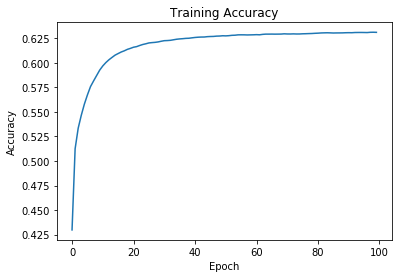

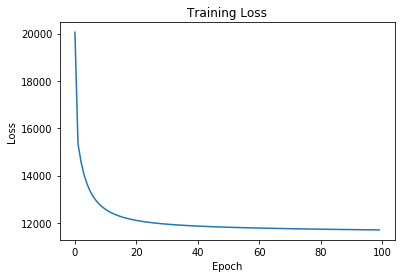




############################################
Training Perceptron 1
    1     0.652560    12231.905876
    2     0.694880    10739.055701
    3     0.702080    10472.110456
    4     0.706140    10314.370700
    5     0.709020    10206.809424
    6     0.710260    10127.458631
    7     0.711080    10066.595688
    8     0.711580    10018.859468
    9     0.712280     9980.712791
   10     0.713060     9949.681195
   11     0.713820     9923.996829
   12     0.714220     9902.374121
   13     0.714760     9883.863739
   14     0.714980     9867.757097
   15     0.715140     9853.521896
   16     0.715900     9840.756755
   17     0.716140     9829.158204
   18     0.716280     9818.496216
   19     0.716780     9808.595928
   20     0.717180     9799.323938
   21     0.717080     9790.578054
   22     0.717260     9782.279604
   23     0.717340     9774.367673
   24     0.717220     9766.794779
   25     0.717300     9759.523625
   26     0.717540     9752.524643
   27     0.717560  

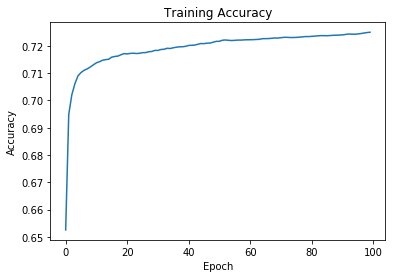

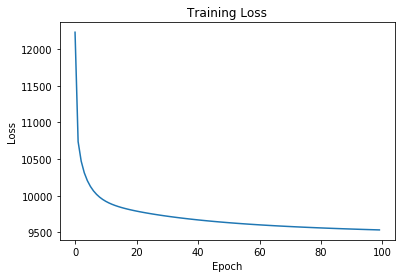




############################################
Training Perceptron 2
    1     0.495820    16447.449886
    2     0.537020    14468.203823
    3     0.539780    14099.851685
    4     0.541580    13901.910663
    5     0.542360    13777.641061
    6     0.542620    13692.213198
    7     0.543420    13629.584819
    8     0.544960    13580.920939
    9     0.545960    13541.052119
   10     0.545560    13506.905705
   11     0.546240    13476.644923
   12     0.546420    13449.165129
   13     0.546560    13423.795434
   14     0.546600    13400.121889
   15     0.546800    13377.882722
   16     0.547500    13356.906235
   17     0.547800    13337.073952
   18     0.548400    13318.298764
   19     0.548960    13300.512000
   20     0.549640    13283.655834
   21     0.549960    13267.678892
   22     0.551080    13252.533766
   23     0.551560    13238.175655
   24     0.552060    13224.561681
   25     0.552680    13211.650578
   26     0.553780    13199.402586
   27     0.553860  

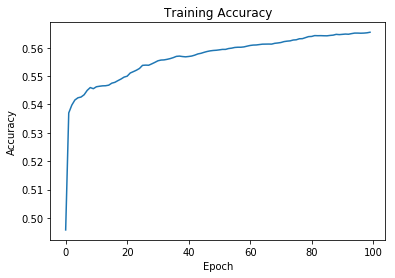

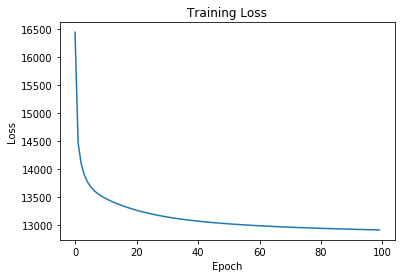




############################################
Training Perceptron 3
    1     0.521580    15853.084848
    2     0.548200    14045.552257
    3     0.553700    13725.684360
    4     0.554540    13551.696749
    5     0.555380    13428.641579
    6     0.556260    13335.441053
    7     0.556700    13261.857720
    8     0.558180    13201.846405
    9     0.558740    13151.553789
   10     0.559160    13108.431199
   11     0.559680    13070.752750
   12     0.560120    13037.325709
   13     0.561140    13007.308506
   14     0.561400    12980.093976
   15     0.562620    12955.233513
   16     0.562320    12932.387323
   17     0.562440    12911.291507
   18     0.563060    12891.736050
   19     0.563540    12873.549960
   20     0.564220    12856.591117
   21     0.564360    12840.739248
   22     0.564420    12825.890992
   23     0.564600    12811.956386
   24     0.565000    12798.856314
   25     0.565540    12786.520620
   26     0.565880    12774.886679
   27     0.566520  

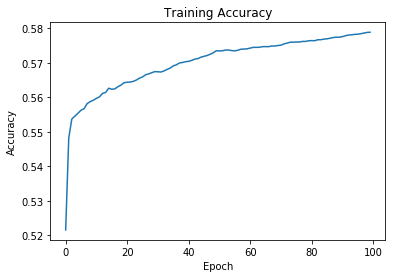

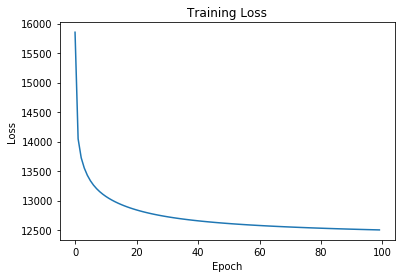




############################################
Training Perceptron 4
    1     0.526740    15919.841073
    2     0.549860    14640.696428
    3     0.551800    14233.468962
    4     0.553720    13957.111123
    5     0.554860    13761.550522
    6     0.557360    13619.773862
    7     0.558920    13513.431483
    8     0.559240    13430.945068
    9     0.560320    13365.054531
   10     0.560220    13311.080391
   11     0.560860    13265.899667
   12     0.561700    13227.362019
   13     0.562900    13193.948915
   14     0.562860    13164.565952
   15     0.562920    13138.410781
   16     0.562780    13114.886073
   17     0.563240    13093.540609
   18     0.563420    13074.028598
   19     0.563720    13056.081168
   20     0.564280    13039.486155
   21     0.565000    13024.073639
   22     0.564900    13009.705508
   23     0.565180    12996.267873
   24     0.565760    12983.665508
   25     0.566200    12971.817756
   26     0.566820    12960.655470
   27     0.567140  

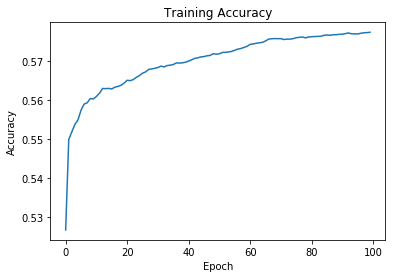

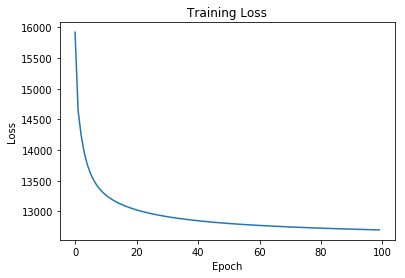




############################################
Training Perceptron 5
    1     0.581120    13911.109175
    2     0.586640    13205.694750
    3     0.592620    12878.002476
    4     0.595460    12692.249295
    5     0.597300    12563.431930
    6     0.598780    12465.078769
    7     0.600780    12386.045887
    8     0.601760    12320.693572
    9     0.602980    12265.646474
   10     0.603780    12218.632471
   11     0.604320    12178.014532
   12     0.605240    12142.568774
   13     0.605720    12111.359886
   14     0.605600    12083.661774
   15     0.606160    12058.903237
   16     0.606780    12036.629470
   17     0.607540    12016.474271
   18     0.607860    11998.139716
   19     0.607960    11981.381115
   20     0.608500    11965.995732
   21     0.608920    11951.814242
   22     0.609540    11938.694160
   23     0.610020    11926.514757
   24     0.610380    11915.173073
   25     0.610800    11904.580763
   26     0.610980    11894.661594
   27     0.611260  

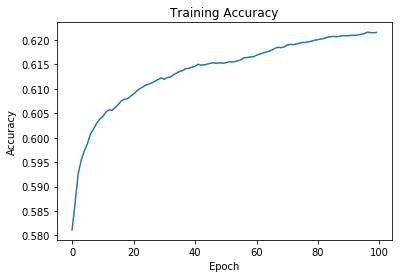

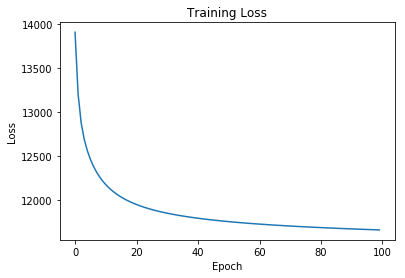




############################################
Training Perceptron 6
    1     0.515140    16145.259564
    2     0.563400    14180.080349
    3     0.570060    13773.386799
    4     0.574460    13549.826016
    5     0.577040    13402.762971
    6     0.579040    13297.490267
    7     0.579620    13217.827027
    8     0.581020    13154.930673
    9     0.582400    13103.553778
   10     0.581820    13060.406792
   11     0.582640    13023.336704
   12     0.583160    12990.883851
   13     0.584060    12962.029398
   14     0.584820    12936.044499
   15     0.585200    12912.396464
   16     0.585900    12890.688359
   17     0.586280    12870.619028
   18     0.586600    12851.955996
   19     0.586920    12834.516772
   20     0.586940    12818.155724
   21     0.587400    12802.754763
   22     0.587800    12788.216634
   23     0.588120    12774.460048
   24     0.588420    12761.416110
   25     0.589240    12749.025670
   26     0.589820    12737.237348
   27     0.590720  

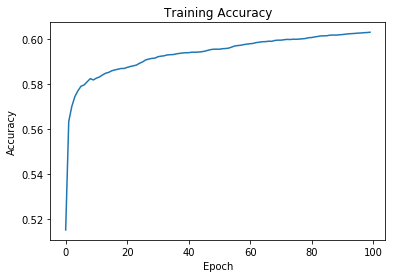

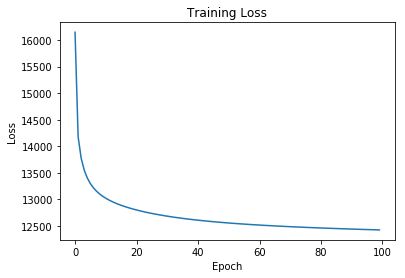




############################################
Training Perceptron 7
    1     0.554600    14660.123823
    2     0.583580    13274.849345
    3     0.590880    12981.162485
    4     0.593860    12813.088265
    5     0.595200    12692.018102
    6     0.596660    12598.083136
    7     0.597260    12522.894423
    8     0.597480    12461.578316
    9     0.598120    12410.782855
   10     0.599020    12368.056588
   11     0.600120    12331.579912
   12     0.600200    12299.997661
   13     0.600520    12272.296523
   14     0.600820    12247.713543
   15     0.601320    12225.668940
   16     0.602000    12205.717446
   17     0.602360    12187.513312
   18     0.602700    12170.785099
   19     0.603100    12155.317438
   20     0.603920    12140.937694
   21     0.603680    12127.506127
   22     0.604240    12114.908546
   23     0.604680    12103.050768
   24     0.605200    12091.854396
   25     0.605480    12081.253580
   26     0.605440    12071.192507
   27     0.605760  

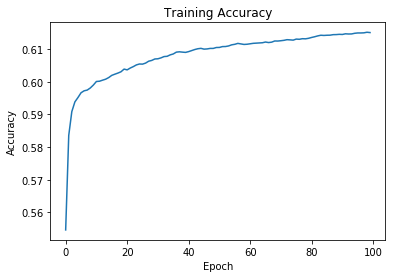

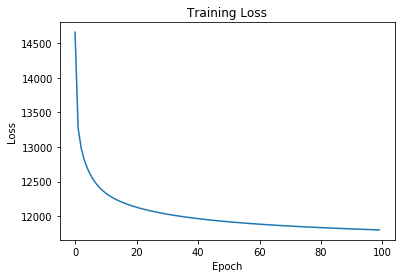




############################################
Training Perceptron 8
    1     0.604900    14091.354167
    2     0.624900    12977.857544
    3     0.632540    12567.319408
    4     0.638500    12255.157282
    5     0.643800    11995.758461
    6     0.648960    11782.281748
    7     0.653720    11607.654747
    8     0.658000    11464.505079
    9     0.661400    11346.461491
   10     0.664300    11248.402880
   11     0.666560    11166.302705
   12     0.668640    11097.009985
   13     0.670580    11038.056970
   14     0.672360    10987.505557
   15     0.673580    10943.827642
   16     0.674560    10905.812657
   17     0.676080    10872.496408
   18     0.677060    10843.106409
   19     0.677700    10817.019922
   20     0.678820    10793.731707
   21     0.679440    10772.829188
   22     0.679920    10753.973265
   23     0.680600    10736.883438
   24     0.681160    10721.326213
   25     0.681220    10707.106032
   26     0.681360    10694.058135
   27     0.681820  

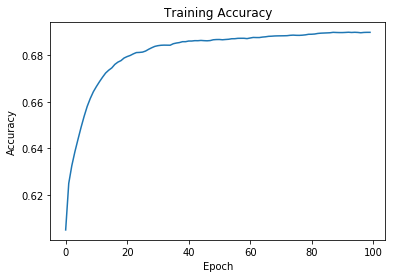

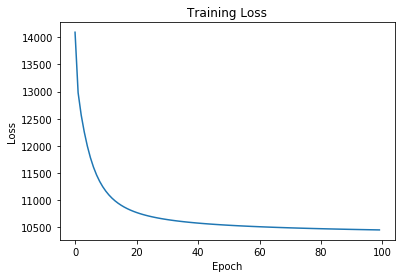




############################################
Training Perceptron 9
    1     0.682500    11250.160229
    2     0.720880    10054.095997
    3     0.726100     9862.644733
    4     0.729440     9743.171240
    5     0.731680     9655.195737
    6     0.734400     9584.736967
    7     0.735620     9525.433554
    8     0.736080     9473.950711
    9     0.737420     9428.362624
   10     0.738320     9387.475355
   11     0.739040     9350.501931
   12     0.739300     9316.890655
   13     0.740040     9286.228912
   14     0.740280     9258.188104
   15     0.740760     9232.492489
   16     0.741660     9208.902131
   17     0.742320     9187.203911
   18     0.743140     9167.206825
   19     0.743320     9148.739339
   20     0.744080     9131.647618
   21     0.744000     9115.794054
   22     0.744440     9101.055877
   23     0.744540     9087.323796
   24     0.745040     9074.500660
   25     0.745460     9062.500179
   26     0.745880     9051.245722
   27     0.746280  

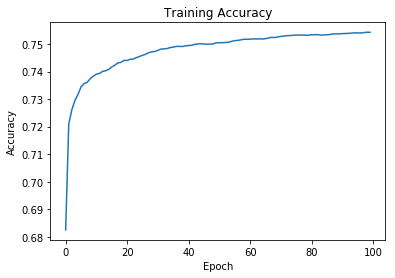

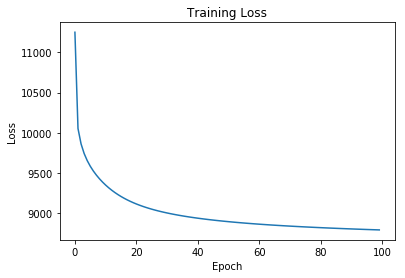

In [16]:
# initializing all 10 perceptrons
perceptrons = [Perceptron(0.001) for i in range(10)]
index = 0

# training all perceptrons
for p in perceptrons:
    print("############################################")
    print("Training Perceptron", index)

    # each perceptron uses its own datasets
    p.train(linear_dataset_array_train[index], 100, "verbose", 10)

    # evaluating each individual perceptron with train and test datasets(only once)
    # notice the overfit difference with the training evaluation
    accuracy_train = p.evaluate(linear_dataset_array_train[index])
    accuracy_test = p.evaluate(linear_dataset_array_test[index])

    print("\nTrain Accuracy: ", accuracy_train, "\tTest Accuracy: ", accuracy_test, "\n")

    p.plotResults()

    print("\n\n")
    index += 1


In [17]:
# creating dataset with numbered class labels
linear_dataset_test_labels = []

for img,category in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    label = classes.index(category)
    linear_dataset_test_labels.append((linear_img,label))


In [18]:
# evaluating final model with test dataset

hits = 0
most_active_perceptron = 0

y_true = []
y_pred = []
    
for image,label in linear_dataset_test_labels:
    y_true.append(label)
    
    image = np.append(image, 1)
    index = 0
    max_output = 0
    
    for p in perceptrons:
        result = p.predict(image)
        if result > max_output:
            
            max_output = result
            most_active_perceptron = index
            
        index += 1
    
    y_pred.append(most_active_perceptron)
    if label == most_active_perceptron:
        hits += 1
    
accuracy = hits / len(linear_dataset_test_labels)

print(accuracy)

cm = confusion_matrix(y_true, y_pred)

0.256


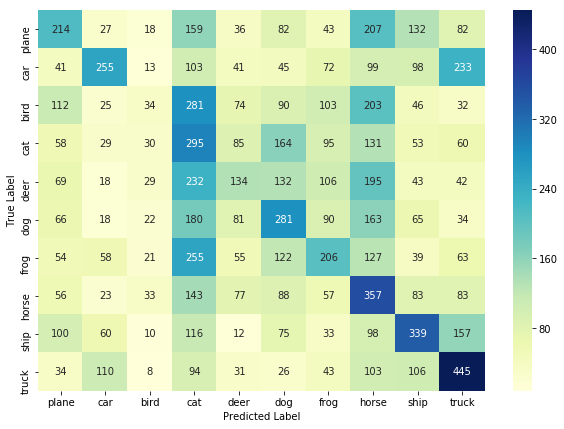

In [19]:
# plotting confusion matrix

df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.YlGnBu, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Considerações Finais
- Arranjo final possui desempenho dentro do esperado.
- Foi necessário tratar true positives com mais significância nos datasets desbalanceados.